In [1]:
import numpy as np

import pandas as pd

import pycountry_convert as pc # for filtering all European countries

import matplotlib.pyplot as plt

# from collections import defaultdict

import itertools

from pingouin import mixed_anova, read_dataset # for mixed/model ANOVA

from Preprocessing_Functions import generate_test_values_matrix
from Preprocessing_Functions import do_np_post_hoc_tests
from Preprocessing_Functions import create_dummies_col

# from IPython.core.debugger import set_trace
from sklearn.svm import SVC # "Support vector classifier"

# used to test for normal distribution before subsituting NaN
from scipy.stats import shapiro 
import scipy.stats as stats

#activate inline plotting to show figures inside the Jupyter Notebook
%matplotlib inline

import seaborn as sns

# set styles for seaborn plots
sns.set_style('darkgrid')
sns.set_color_codes(palette='pastel')

# Reading in data and preprocessing

In the following, data is read in and cleaned by
 - removing all columns with less than 40% values
 - removing all NaN values from the column to predict (e.g. the converted salary)
 - removing columns which are derivatives of each other as they are linearly dependent and thus do not help in explaining variance in the dataset
 - converting columns to numeric values where appropriate (e.g. hours of work per week)
 - removing outliers from numeric columns based on column-specific premises (e.g. work hours of more than 126h per week)
 - filling in NaN values in columns based on the distribution of data in that column (mean is used for normally distributed data, median is used for non-normal distributions)

As the dataset is too large to upload it on Github, please download it from <br>
https://drive.google.com/file/d/1dfGerWeWkcyQ9GX9x20rdSGj7WtEpzBB/view?usp=sharing
<br>

In [2]:
df = pd.read_csv("developer_survey_2020/survey_results_public.csv")
schema = pd.read_csv("developer_survey_2020/survey_results_schema.csv")

In [3]:
# drop all columns for which less than 40% of data were registered
dfs = df.dropna(axis=1, thresh=np.round(df.shape[0]*0.4))

# get the index of all NaN values in 'ConvertedComp' and remove 
# corresponding rows from the dataframe
idx = np.array(dfs['ConvertedComp'].isna())
dfs = dfs.drop(axis=0, index=df.index[idx])

In [4]:
# Select relevant subset of columns
# CompFreq and CompTotal are direct derivatives of ConvertedComp and would 
# distort results
idx_remove = ['CompFreq', 'Respondent', 'CompTotal', 'DatabaseDesireNextYear',
              'JobSeek', 'DatabaseWorkedWith', 'LanguageDesireNextYear', 
              'MiscTechDesireNextYear', 'NEWCollabToolsDesireNextYear', 
              'NEWDevOps', 'NEWDevOpsImpt', 'NEWJobHunt', 
              'NEWJobHuntResearch','PurchaseWhat', 'SurveyEase', 
              'CurrencyDesc', 'SurveyLength', 'WebframeDesireNextYear', 
              'PlatformDesireNextYear','NEWPurchaseResearch', 'Ethnicity',
              'Sexuality', 'CurrencySymbol', 'NEWSOSites','SOVisitFreq']
dfs = dfs.drop(columns=idx_remove, axis=1)

# ------ CONVERT CATEGORICAL TO NUMERIC VARIABLES WHERE APPROPRIATE ------ 

# cast years of coding to numeric type by substituting with the "mean" of 
# reasonable timespans, i.e. 'More than 50 years' is substituted with 55 years
#  - assuming maximum employment duration to be 70 and start of programming 
# professionally to 15, resulting max professional coding experience is 55 
# (70-15)
dfs.YearsCodePro.replace({'Less than 1 year': '0.5', 
                          'More than 50 years': '55'}, inplace=True)
dfs.YearsCodePro = dfs.YearsCodePro.astype(np.number)

dfs.YearsCode.replace({'Less than 1 year': '0.5', 
                       'More than 50 years': '60'}, inplace=True)
dfs.YearsCode = dfs.YearsCode.astype(np.number)

dfs.Age1stCode.replace({'Older than 85': '90', 
                        'Younger than 5 years': '4'}, inplace=True)
dfs.Age1stCode = dfs.Age1stCode.astype(np.number)

In [5]:
# ------ REMOVE OUTLIERS FROM NUMERIC COLUMNS --------

# I assume some people have listed their yearly income (e.g. 120.000) but 
# provided frequency 'weekly', resulting in very high ConvertedComp values 
# which are implausible given other data (age, work hours)
for feat in ['ConvertedComp', 'Age']:
    idx = np.array(dfs[feat] >= dfs[feat].quantile(.97))
    dfs = dfs.drop(axis=0, index=dfs.index[idx])

# assuming 6h per day minimum for eating, sleeping, buying groceries,... 
# maximum work hours per week are 126. Everything above will be substituted by
# the median dfs.replace({'WorkWeekHrs':126}, dfs['WorkWeekHrs'].median(), 
# inplace=True)
mask = dfs.WorkWeekHrs >125
dfs.loc[mask, 'WorkWeekHrs'] = dfs['WorkWeekHrs'].mean()
dfs.fillna(value={'WorkWeekHrs': dfs['WorkWeekHrs'].mean()}, inplace=True)

In [6]:
# ------ SUBSTITUTE NANs --------

# substitute with mean or median depending on distribution type
# for col in dfs.columns:
#     if dfs[col].dtype == np.number:
#         stat, p = shapiro(np.array(dfs[col]))
# #         k, p2 = stats.normaltest(np.array(dfs[col]), nan_policy='omit') 
#         if p > 0.05:
#             print(col, ': Distribution is Gaussian')
#             print('Result from normaltest: ', p2)
#             mask = dfs[col].isna()
#             dfs.loc[mask, col] = dfs[col].mean()
#             #dfs[col][dfs[col].isna()] = dfs[col].mean()
#         else:
#             print(col, ': Distribution is not Gaussian')
#             print('Result from normaltest: ', p2)
#             mask = dfs[col].isna()
#             dfs.loc[mask, col] = dfs[col].median()
#             #dfs[col][dfs[col].isna()] = dfs[col].median()   

## Add necessary new columns

__Create individual columns for multiple-selection items in the questionnaire__

In [7]:
dfs['EdLevel'].replace({'Associate degree (A.A., A.S., etc.)':'Associate',
                        'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 
                        'Bachelor',
                        'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)':
                        'Master', 
                        'Other doctoral degree (Ph.D., Ed.D., etc.)':
                        'Doctorate', 
                        'Professional degree (JD, MD, etc.)':'Doctorate',
                        'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)':
                        'Sec_school',
                        'Some college/university study without earning a degree':
                        'Sec_school',
                        'Primary/elementary school':'Prim_School',
                        'I never completed any formal education':'No_ed'
                       }, inplace=True)

In [8]:
# some items in the questionnaire allowed for multiple answers. 
# Each unique combination of these is listed as a value-concatenation 
# delimited by ';'. 
# For further analysis, we need to split this again into separate columns

for col in ['DevType', 'JobFactors', 'EdLevel']:
    # prevent creating dummies for a variable twice
    if col in dfs.columns:
        dfs = create_dummies_col(df_in=dfs, col=col, delim=';', 
                                 delete_original=True)

__Clean / shorten labels and dichotomize__

In [9]:
# Dichotomize Education into higher education (i.e. minimum a university
# degree) and others (e.g. primary / secondary school)
dfs['HigherEd'] =  (dfs['EdLevel_Associate'] + dfs['EdLevel_Bachelor'] + 
                    dfs['EdLevel_Doctorate'] + dfs['EdLevel_Master'])

**Add new gender column**<br>
Generate a new column that only distinguishes male, female and genderqueer. 
Many participants chose combinations of genderqueer and one of male or female, 
thus labels cannot be easily substituted

In [10]:
# break up ';'-delimited labels into columns
dfs = create_dummies_col(dfs, 'Gender', ';', False)
dfs['Gender'] = dfs.Gender_Man + (dfs.Gender_Woman*2) + \
            (dfs['Gender_Non-binary, genderqueer, or gender non-conforming']*3)

# remove old dummies columns
dfs.drop(columns = ['Gender_Man', 
                    'Gender_Non-binary, genderqueer, or gender non-conforming', 
                    'Gender_Woman'], inplace = True)

# now 0=NaN, 1=Male, 2=Female, 3=Gender non-binary etc.
dfs.replace({'Gender':[4,5,6]}, 3, inplace=True)

# generate a column holding string data
dfs['Genderlabels'] = dfs['Gender'].copy()
dfs.replace({'Genderlabels':1}, 'Male', inplace=True)
dfs.replace({'Genderlabels':2}, 'Female', inplace=True)
dfs.replace({'Genderlabels':3}, 'Genderqueer', inplace=True)
dfs.replace({'Genderlabels':0}, None, inplace=True)

__Add a column for continent__<br>
This allows us to to filter by geographic area when comparing work hours or income

In [11]:
dfs['Country'].reset_index(drop=True)
countries = pd.Series(dfs['Country'])

# accesses the first group match of a python regex
repl = lambda m: m.group(1)
# Strips Country names to the first word, ([a-z|A-Z]*)[,].*$ and remove some 
# special cases i.e. "Venezuela, Bolivarian Republic of...'" is changed to 
# "Venezuela"
countries = countries.str.replace('([a-z|A-Z]*)[,].*$', repl, case=False)
countries = countries.str.replace('Republic of Korea', 'North Korea', 
                                  case=True)
countries = countries.str.replace('The former Yugoslav Republic of Macedonia', 
                                  'Macedonia', case=True)
countries = countries.str.replace('Hong Kong (S.A.R.)', 'Hong Kong', 
                                  regex=False)

# generate two arrays holding the country code and continent code
country_code = []
continent_code = []
for x in np.arange(0,dfs.shape[0],1):
    try:
        country_code.append(pc.country_name_to_country_alpha2(
            countries.iloc[x], cn_name_format="default"))
        continent_code.append(pc.country_alpha2_to_continent_code(
            country_code[-1]))
    except KeyError:
        if countries.iloc[x] == 'Kosovo':
            continent_code.append('EU')
            country_code.append(None)
        else:
            country_code.append(None)
            continent_code.append(None)

# add country and continent code to the dataset
dfs.insert(0, column='CountryCode', value=country_code)
# remove country names - same information content as Country Code
# dfs.drop(columns='Country', inplace=True)
dfs.insert(0, column='Continent', value=continent_code)

__Add a normalized income column__

In [12]:
# calculate mean and standard deviation per continent and add it as column 
# to the dataframe
means_stds = dfs.groupby('Continent')['ConvertedComp'].agg(['mean','std'])
means_stds.reset_index()
dfs = dfs.merge(means_stds, on='Continent')
del means_stds

# calculate the normalized compensation value per continent and add it in a 
# new column
dfs['CComp_norm'] = (dfs['ConvertedComp'] - dfs['mean']) / dfs['std']

# remove the added "mean" and "std" column from the dataframe
dfs.drop(columns=['mean', 'std'], inplace=True)

# Analyze, Model, and Visualize
## Sanity check
To verify whether we made some big errors in data cleaning or have outliers which massively distort the data, we look at the correlation values of the numeric columns.
The results appear plausible at first glance:
- Age and years of professional coding experience are highly and positively correlated, i.e. the older you are, the longer you coded professionally
- Normalized income (ConvertedComp) and age as well as years of coding experience are moderately positively correlated, i.e. there is a tendency that you earn more the older you are and the longer you program professionally

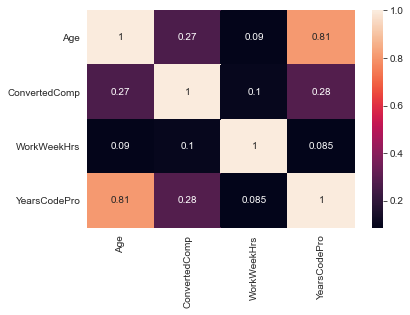

In [13]:
sns.heatmap(
    dfs[['Age', 'ConvertedComp', 'WorkWeekHrs', 'YearsCodePro']].corr(), 
    annot=True, fmt='.2g'
)
plt.savefig('Figures/CorrelationMatrix.png', bbox_inches='tight', 
            pad_inches=0.3)

## Question: is it worth it (financially), doing a PhD?

__Preprocessing__

In [14]:
df = dfs.copy()
# generate a copy of the filtered dataframe
df = df.loc[df.Continent.isin(['EU','NA'])];
df = df.loc[df.MainBranch == 'I am a developer by profession'];

# filter out people working in academia as payment is usually regulated 
# differently than in a company for them
df = df.loc[dfs['DevType_Academic researcher'] == 0];

# we are only interested in the comparison of PhD vs. all other types of
# higher / university education, we need to create a predictor column based
# on the dummy columns (each contains only 0, 1 or NaN)
df['PhD_vs_HigherEd'] =  df.HigherEd + df.EdLevel_Doctorate;

# assign human-readable labels for plotting
df.PhD_vs_HigherEd.replace({0:'no university Ed', 1:'Higher Ed', 
                            2:'Doctorate'}, inplace=True)

__Exploratory Visualization__

In [15]:
# deactivate inline plotting
%matplotlib qt 
jg = sns.displot(data=df, x='ConvertedComp', hue='PhD_vs_HigherEd', 
            col='Continent', kind='ecdf')

jg.set_xlabels(label = 'Compensation before taxes in USD');
jg.set_ylabels(label = 'Proportion of data');

jg.tight_layout()
plt.show()
plt.savefig('Figures/Salary_by_Education.png', bbox_inches='tight', 
            pad_inches=0.3)

# reactivate inline plotting
%matplotlib inline 

__Statistical Analysis__

In [16]:
tdf = df[['ConvertedComp', 'PhD_vs_HigherEd', 'Continent', 'YearsCodePro']].copy()
tdf = tdf.reset_index(drop=True)
tdf['Subject'] = tdf.index
tdf.dropna(how='any', axis=0, inplace=True)

In [17]:
mixed_anova(data=tdf, 
            dv='ConvertedComp', 
            within='Continent',
            subject='Subject', 
            between='PhD_vs_HigherEd', 
            correction='auto')

/usr/local/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:7605: RuntimeWarning: Degrees of freedom <= 0 for slice
  baseCov = np.cov(mat.T)
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,PhD_vs_HigherEd,5.027725e+11,2,12378,2.513862e+11,14.299928,6.263017e-07,0.002305,NaN
1,Continent,1.123192e+13,1,12378,1.123192e+13,-1158.074226,1.000000e+00,-0.103216,1.0
2,Interaction,-2.315196e+11,2,12378,-1.157598e+11,11.935493,6.629383e-06,0.001925,NaN


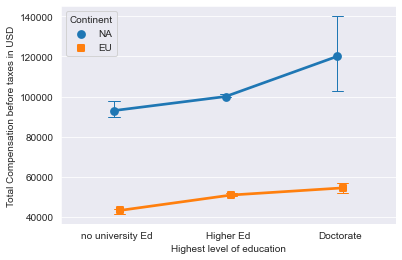

In [18]:
sns.pointplot(data=tdf, x='PhD_vs_HigherEd', y='ConvertedComp', 
              hue='Continent', dodge=True, markers=['o', 's'],
              capsize=.1, errwidth=1, 
              order=['no university Ed', 'Higher Ed', 'Doctorate'],
              ci = 90,
              estimator=np.median)
plt.xlabel('Highest level of education')
plt.ylabel('Total Compensation before taxes in USD')
plt.savefig('Figures/Salary_by_EducationLevel_Pointplot.png', 
            bbox_inches='tight', 
            pad_inches=0.3)

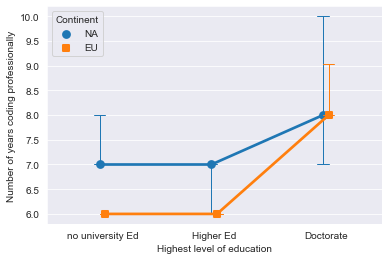

In [19]:
sns.pointplot(data=tdf, x='PhD_vs_HigherEd', y='YearsCodePro', 
              hue='Continent', dodge=True, markers=['o', 's'],
              capsize=.1, errwidth=1, 
              order=['no university Ed', 'Higher Ed', 'Doctorate'],
              estimator=np.median)
plt.xlabel('Highest level of education')
plt.ylabel('Number of years coding professionally')
plt.savefig('Figures/YearsCodePro_by_EducationLevel_Pointplot.png', 
            bbox_inches='tight', 
            pad_inches=0.3)

In [20]:
mixed_anova(data=tdf, 
            dv='YearsCodePro', 
            within='Continent',
            subject='Subject', 
            between='PhD_vs_HigherEd', 
            correction='auto')

/usr/local/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:7605: RuntimeWarning: Degrees of freedom <= 0 for slice
  baseCov = np.cov(mat.T)
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,PhD_vs_HigherEd,2620.762521,2,12378,1310.381261,8.529000,0.000199,0.001376,NaN
1,Continent,2858.558602,1,12378,2858.558602,-36.995970,1.000000,-0.002998,1.0
2,Interaction,1371.439611,2,12378,685.719805,-8.874707,1.000000,-0.001436,NaN


## Question: is there a difference in income by continent?
### Visualize the distribution of income by continent
There appears to be a difference in central tendency for the distributions, indicating lower income in Asia, South America and Africa as opposed to Europe and North America. Of course there might be confounding factors such as different numbers of participants, age groups, developer types which cannot all be exluded from analysis.

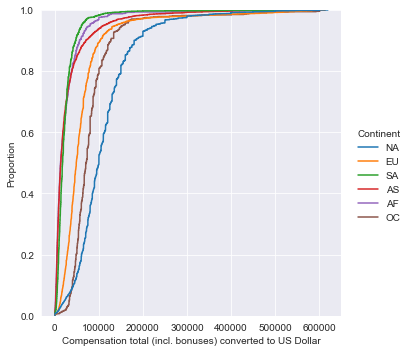

In [21]:
# plot the distribution as density estimate
plottype='ecdf'
filename = 'Figures/Compensation_by_Continent_' + plottype + '.png'

sns.displot(data=dfs, x='ConvertedComp', hue='Continent', 
            kind=plottype)
plt.xlabel('Compensation total (incl. bonuses) converted to US Dollar')
plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)

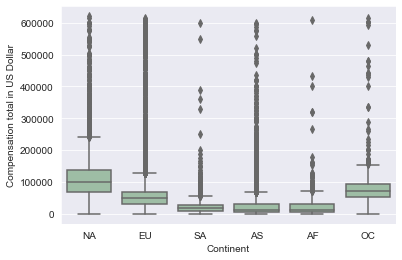

In [22]:
# if you'd rather look at a boxplot
df = dfs[['ConvertedComp', 'Continent']].copy()
df = pd.melt(df.reset_index(), id_vars=['Continent'], 
                  value_vars=['ConvertedComp'])

sns.boxplot(x='Continent', y='value', data=df, color='#99c2a2')
filename = 'Figures/Salary_by_Continent_boxplot.png'
plt.ylabel('Compensation total in US Dollar')

plt.savefig(filename, bbox_inches='tight')
del df, filename

### Perform statistical tests
As the data does not look normally distributed, choose a nonparametric alternative to a two-way ANOVA.
In this case, the Kruskal-Wallis test is used because there are more than two levels, i.e. continents, of the independent variable and the data are from independent samples, i.e. each income value is from different people participating in the survey

Do Mann-Whitney tests for some pairwise comparisons of interest. 
We need to correct alpha for the number of tests we are doing, here using Bonferroni-correction for multiple comparisons.

__Functions used for test preparation (imported from Preprocessing_Functions.py)__
<ol>
    <li>generate_test_values_matrix : takes strings for factor / independent variable (X) and dependent variable (y) and generates a test matrix of size (nsamples x factor-levels) used for statistical testing.</li>
    <li>do_np_post_hoc_tests : does nonparametric pairwise comparisons for the combinations of columns in an (nsamples x factor-levels) test matrix listed in <i>indices</i></li>
</ol>

In [23]:
t_labels, t_vals, df_test = generate_test_values_matrix(
    data = dfs, y='ConvertedComp', str_X='Continent')

# as the data does not look normally distributed, due to the long tails, 
# we need to revert to the nonparametric alternative to a two-way ANOVA, e.g. 
# a Kruskal-Wallis Test
statistic, pvalue = stats.kruskal(*t_vals, nan_policy='omit')
print('P value of Kruskal-Wallis H-Test: ', pvalue)
print('H statistic of Kruskal-Wallis Test:', statistic)

Number of observations for  AF =  877
Number of observations for  AS =  5837
Number of observations for  EU =  14310
Number of observations for  NA =  9032
Number of observations for  OC =  870
Number of observations for  SA =  1854
P value of Kruskal-Wallis H-Test:  0.0
H statistic of Kruskal-Wallis Test: 13093.603488072049


In [24]:
## Calculate the post-hoc tests for the Kruskal-Wallis test

# get all possible group combinations
comb = itertools.combinations(np.arange(0,len(t_labels)), 2)
indices = [i for i in comb]
labels = [t_labels[i[0]] + ' vs. ' + t_labels[i[1]] for i in indices]

do_np_post_hoc_tests(t_vals, labels, indices, 0.05, True)

# clear variables we no longer need
# del labels, indices, t_vals, t_labels, statistic, pvalue, df_test

Alpha value after Bonferroni correction:  0.0033333333333333335 



,label,Pval,U-stat,is_significant
0,AF vs. AS,1.435478e-01,2502550.0,False
1,AF vs. EU,8.366131e-220,2289227.5,True
2,AF vs. NA,0.000000e+00,615021.5,True
3,AF vs. OC,4.943716e-192,70119.0,True
4,AF vs. SA,8.511964e-08,712370.5,True
5,AS vs. EU,0.000000e+00,16536235.5,True
6,AS vs. NA,0.000000e+00,5331846.5,True
7,AS vs. OC,3.808651e-289,603952.5,True
8,AS vs. SA,1.968252e-13,4806424.5,True
9,EU vs. NA,0.000000e+00,27852710.0,True


## Question: Does income in Europe and North America depend on the size of the organisation?
Transform labels in the OrgSize column to make it more readable

In [25]:
# ------ Shorten labels in OrgSize to make plots readable -------
df = dfs.copy()
df.OrgSize = df.OrgSize.str.replace(' employees','')
df.OrgSize = df.OrgSize.str.replace(' - I am a freelancer, sole proprietor, etc.','')

# specify custom sort order for column 'OrgSize', else strings are sorted by
# the first character.
org_sizes = ['Just me', '2 to 9', '10 to 19', '20 to 99', '100 to 499', 
             '500 to 999', '1,000 to 4,999', '5,000 to 9,999', 
             '10,000 or more']

# as the function astype no longer accepts multiple arguments, 
# first generate a data type object with the desired properties
org_size_dtype = pd.api.types.CategoricalDtype(categories=org_sizes, 
                                               ordered=True)
df = df.astype({'OrgSize':org_size_dtype})

# delete variables that are no longer needed
del org_size_dtype, org_sizes

In [26]:
# generate a separate column for the comparison North America - Europe
df['NA_EU'] = df['Continent'].copy()
df['NA_EU'].replace({'AF':np.NaN, 'AS':np.NaN, 'OC':np.NaN, 'SA':np.NaN}, 
                     inplace=True)

# remove data from other continents by filtering NaNs. 
# Remove missing data for OrgSize columns
df.dropna(axis=0, how='any', inplace=True, subset=['OrgSize', 'NA_EU'])

grouper = df.groupby(by=['OrgSize', 'NA_EU'], sort=True)

format_dict = {'mean':'{:,.0f}', 'std':'{:,.0f}',
               'min':'{:,.0f}', 'max':'{:,.0f}'}

grouper['ConvertedComp'].agg(['mean','std','min', 'max']).style.format(format_dict)

### Preprocessing
Add a column "Company_Size" to have a coarser binning for company sizes.

In [27]:
df['Company_Size'] = df['OrgSize'].copy()
df['Company_Size'].replace({'Just me':'1-9', 
                             '2 to 9':'1-9', 
                             '10 to 19':'10-99',
                             '20 to 99':'10-99', 
                             '100 to 499':'100-999', 
                             '500 to 999':'100-999', 
                             '1,000 to 4,999':'1,000-10,000', 
                             '5,000 to 9,999':'1,000-10,000'},
                             inplace=True)

# again specify custom sort order for column 'Company_Size'
org_sizes = ['1-9', '10-99', '100-999', '1,000-10,000'];
org_size_dtype = pd.api.types.CategoricalDtype(categories=org_sizes, 
                                               ordered=True)
df = df.astype({'Company_Size':org_size_dtype})

# remove rows without company size information
df.dropna(axis='index', how='any', subset=['Company_Size'], inplace=True)

Add a column with normalized compensation values per continent that is calculated by subtracting the continent-specific mean and dividing by the std for each sample belonging to that continent.

In [28]:
# calculate mean and standard deviation per continent and add it as column 
# to the dataframe
means_stds = df.groupby('Continent')['ConvertedComp'].agg(['mean','std'])
means_stds.reset_index()
df = df.merge(means_stds, on='Continent')
del means_stds

# calculate the normalized compensation value per continent and add it in a 
# new column
df['CComp_norm'] = (df['ConvertedComp'] - df['mean']) / df['std']

# remove the added "mean" and "std" column from the dataframe
df.drop(columns=['mean', 'std'], inplace=True)

### Visualization
To get an impression of the data, we first visualize total compensation by
organisation size for both North America and Europe. 
The first plot shows a density overlay while the second plots the same data as cumulative density function.

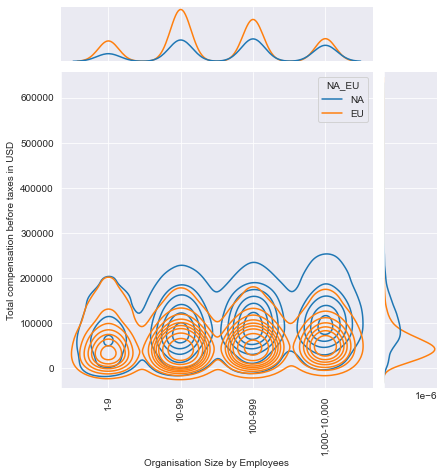

<Figure size 432x288 with 0 Axes>

In [29]:
grouper = df.groupby('Company_Size')
df['num_OrgSize'] = grouper.ngroup()

# generate x Ticklabels in the grouping order for later plotting (legend)
labels = []
for i in np.arange(0, grouper.ngroups, 1):
    mask = (df.num_OrgSize == i)
    val = np.unique(df.loc[mask, 'Company_Size'])
    if len(val) > 0:
        labels.append(val[0])
del val, mask, i

jg = sns.jointplot(data=df, x='num_OrgSize', y='ConvertedComp', 
              hue='NA_EU', color="#4CB391", kind='kde')

jg.ax_joint.set_xticks(ticks = np.unique(df.num_OrgSize));
jg.ax_joint.set_xticklabels(labels=labels, rotation=90)

jg.set_axis_labels(xlabel = 'Organisation Size by Employees', 
                   ylabel = 'Total compensation before taxes in USD');
plt.axis('auto');
plt.show()
plt.savefig('Figures/Salary_by_OrgSize.png', bbox_inches='tight', 
            pad_inches=0.1);

The next plot shows cumulative density estimates for total compensation for each continent and is left just out of curiosity

In [30]:
# Generate a custom plot using a 2x3 grid of subplots
# allow plotting outside the notebook
%matplotlib qt 

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,20), 
                         sharex=True, sharey=True)
ax_idx = 0

for name, group in df.groupby('Continent'):
    # plot axes only on rightmost subplots
    legend_val = False
    if (ax_idx == 5) | (ax_idx == 2):
        legend_val = True
    
    # plot the cumulative density to the respective subplot axis
    ax = sns.ecdfplot(x=group['ConvertedComp'].values, 
                      hue=group['OrgSize'].values,
                      palette='twilight', ax=axes[ax_idx//3,ax_idx%3], 
                      legend=legend_val
                     )
    ax.set_title(name)
    ax_idx += 1
    
# save plots to current directory
plt.savefig('Figures/Income_Continent.png', bbox_inches='tight')
plt.savefig('Figures/Income_Continent.pdf', bbox_inches='tight')

# reset to plotting inside notebook
%matplotlib inline 

### Statistical testing

In [31]:
out = []
for country in ['EU', 'NA']:
    mask = df['Continent'].isin([country]);
    t_df = df.loc[mask, ['Continent', 'ConvertedComp', 'Company_Size']].copy();

    t_labels, t_vals, df_test = generate_test_values_matrix(
        data = t_df, y='ConvertedComp', str_X='Company_Size')

    # as the data does not look normally distributed, due to the long tails, 
    # we need to revert to the nonparametric alternative to a two-way ANOVA
    stat, pval = stats.kruskal(*t_vals, nan_policy='omit')
    print(country, ' - P value of Kruskal-Wallis H-Test: ', pval)
    print(country, ' - H statistic of Kruskal-Wallis Test:', stat)
    
    # get all possible group combinations
    comb = itertools.combinations(np.arange(0,len(t_labels)), 2);
    indices = [i for i in comb];
    labels = [t_labels[i[0]] + ' vs. ' + t_labels[i[1]] for i in indices];

    dfp = do_np_post_hoc_tests(t_vals, labels, indices, 0.025, True);
    out.append(dfp)

Number of observations for  1-9 =  1857
Number of observations for  10-99 =  4716
Number of observations for  100-999 =  3810
Number of observations for  1,000-10,000 =  2064
EU  - P value of Kruskal-Wallis H-Test:  1.155480955509377e-34
EU  - H statistic of Kruskal-Wallis Test: 160.92844416773252
Alpha value after Bonferroni correction:  0.004166666666666667 

Number of observations for  1-9 =  800
Number of observations for  10-99 =  2222
Number of observations for  100-999 =  2336
Number of observations for  1,000-10,000 =  1669
NA  - P value of Kruskal-Wallis H-Test:  1.150290044435623e-61
NA  - H statistic of Kruskal-Wallis Test: 285.84618466316834
Alpha value after Bonferroni correction:  0.004166666666666667 



__Visualize post-hoc test results for European companies__

In [32]:
# formatting for Styler object to render a readable table
format_dict = {'Pval':'{:,.4f}', 'U-stat':'{:,.0f}'}

def _color_red_or_green(val):
    color = 'green' if val else 'grey'
    return 'color: %s' % color

# apply format dict styling first and only to a subset of columns. Then
# apply another style to the last column, highlighting significance in green.
out[0].style.format(format_dict, 
                    subset = pd.IndexSlice[:, ['Pval', 'U-stat']]).applymap(
                        lambda x: "color: green" \
                        if x else "color: red", 
                        subset=pd.IndexSlice[:, ['is_significant']])

,label,Pval,U-stat,is_significant
0,1-9 vs. 10-99,0.2277,"4,327,114",False
1,1-9 vs. 100-999,0.0000,"3,238,133",True
2,"1-9 vs. 1,000-10,000",0.0000,"1,600,996",True
3,10-99 vs. 100-999,0.0000,"8,222,356",True
4,"10-99 vs. 1,000-10,000",0.0000,"4,002,932",True
5,"100-999 vs. 1,000-10,000",0.0000,"3,540,446",True


__EUROPE__<br>
Show median and percentiles to determine the direction of the difference

In [33]:
dft = df[df['Continent'] == 'EU'].copy()
dft.groupby(by=['Company_Size'], sort=True)['ConvertedComp'].describe()

,count,mean,std,min,25%,50%,75%,max
Company_Size,,,,,,,,
1-9,1857.0,60209.082391,64741.556848,0.0,25944.0,44100.0,71340.0,596700.0
10-99,4716.0,59634.866200,71883.361229,0.0,29832.0,45396.0,64859.0,613656.0
100-999,3810.0,61835.450656,66939.330668,0.0,33924.0,48936.0,68507.0,609672.0
"1,000-10,000",2064.0,67099.774709,65248.448244,0.0,37620.0,54089.0,76329.0,604932.0


__Visualize post-hoc test results for North American companies__

In [34]:
out[1].style.format(format_dict)
out[1].style.format(format_dict, 
                    subset = pd.IndexSlice[:, ['Pval', 'U-stat']]).applymap(
                        lambda x: "color: green" \
                        if x else "color: red", 
                        subset=pd.IndexSlice[:, ['is_significant']])

,label,Pval,U-stat,is_significant
0,1-9 vs. 10-99,0.0000,"753,256",True
1,1-9 vs. 100-999,0.0000,"682,333",True
2,"1-9 vs. 1,000-10,000",0.0000,"437,842",True
3,10-99 vs. 100-999,0.0000,"2,232,660",True
4,"10-99 vs. 1,000-10,000",0.0000,"1,428,193",True
5,"100-999 vs. 1,000-10,000",0.0000,"1,756,530",True


__NORTH AMERICA__<br>Show median and percentiles to determine the direction of the difference

In [35]:
dft = df[df['Continent'] == 'NA'].copy()
dft.groupby(by=['Company_Size'], sort=True)['ConvertedComp'].describe()

,count,mean,std,min,25%,50%,75%,max
Company_Size,,,,,,,,
1-9,800.0,88088.035000,77897.513295,0.0,38688.00,72000.0,120000.0,600000.0
10-99,2222.0,95581.504050,59303.548216,0.0,60000.00,88000.0,122750.0,589920.0
100-999,2336.0,105196.283390,52977.982219,0.0,71069.75,100000.0,133250.0,576000.0
"1,000-10,000",1669.0,120653.324745,74123.566837,0.0,78000.00,105884.0,142700.0,600000.0


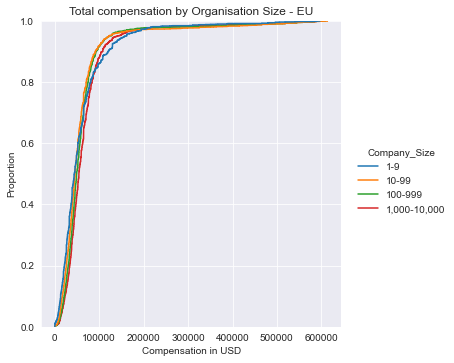

In [36]:
mask = df['Continent'].isin(['EU']);
t_df = df.loc[mask, ['Continent', 'ConvertedComp','Company_Size']].copy()

sns.displot(data=t_df, x='ConvertedComp', hue='Company_Size', kind='ecdf')
plt.title('Total compensation by Organisation Size - EU');
plt.xlabel('Compensation in USD');
plt.savefig('Figures/EU_Compansation_by_CompanySize.png', bbox_inches='tight')

# clear variables we no longer need
# del comparisons, indices, test_values, name, group, statistic, pvalue, df, i

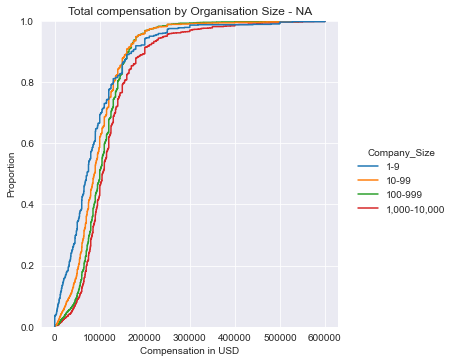

In [37]:
mask = df['Continent'].isin(['NA']);
t_df = df.loc[mask, ['Continent', 'ConvertedComp','Company_Size']].copy()

sns.displot(data=t_df, x='ConvertedComp', hue='Company_Size', kind='ecdf')
plt.title('Total compensation by Organisation Size - NA');
plt.xlabel('Compensation in USD');
plt.savefig('Figures/NA_Compansation_by_CompanySize.png', bbox_inches='tight')
# clear variables we no longer need
# del comparisons, indices, test_values, name, group, statistic, pvalue, df, i

## Extra question: can we predict job satisfaction / branch of work based on compensation, work hours,...?
I wanted to use an unsupervised model to determine whether I can, for example, predict the main branch of work (e.g. if somebody is a full stack developer vs. a frontend developer) based on their salary and work hours per week. 

Rather than the main branch, the model can equally be trained on job satisfaction. 

The results do look strange, so I did not include this analysis in the report.

In [38]:
# # If necessary: uncomment to create a combined factor for prediction
# grouper= dfs.groupby(['OrgSize', 'Continent'])
# dfs['OrgSize_x_Continent'] = grouper.ngroup()

# Define factors used for prediction
factors = ['WorkWeekHrs', 'CComp_norm'];
predictor = ['MainBranch']

continent = ['NA'] # continent to restrict analysis to
continent_str = 'North America' # name used for plotting

if predictor[0] == 'JobSat':
    # Dichotomize Job Satisfaction
    dfs['is_Satisfied'] = dfs.JobSat.copy()
    dfs.is_Satisfied.replace({'Neither satisfied nor dissatisfied':np.nan, 
                              'Slightly dissatisfied':'Not satisfied',
                              'Very dissatisfied':'Not satisfied',
                              'Slightly satisfied':'Satisfied', 
                              'Very satisfied':'Satisfied'}, inplace=True)

dfs_svm = dfs.dropna(axis=0, how='any', subset=[*factors, *predictor])
mask = dfs_svm['Continent'].isin(continent);

In [39]:
# SVC takes two arrays as input: an array X (n_samples, n_features) holding 
# the training samples, and an array y (strings or integers), of shape 
# (n_samples,1)

X = np.array(dfs_svm.loc[mask, factors]).reshape([-1,2])
y = np.array(dfs_svm.loc[mask, predictor]).ravel()

print('using ', X.shape[0], ' samples and ', X.shape[1], 
      ' factors for prediction')
print('using ', y.shape, ' predictor samples')

using  9032  samples and  2  factors for prediction
using  (9032,)  predictor samples


The following code - in particular the plotting functions - is (partly adapted) from https://scikit-learn.org/0.18/_sources/auto_examples/svm/plot_iris.txt (BSD license)

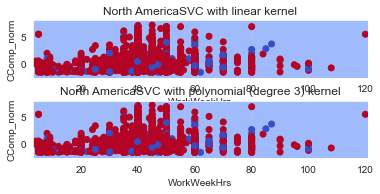

In [40]:
poly_svc = SVC(kernel='poly', degree=3)
poly_svc.fit(X, y);

linear_svc = SVC(kernel='linear')
linear_svc.fit(X, y);

h = 0.2
continent_str = 'North America'
# Transform predictor variable to numeric [0, 1] for plotting
# y must not contain more than two different values
y_colors = np.array([i == y[0] for i in y]).astype(int)

# title for the plots
titles = [continent_str + 'SVC with linear kernel',
          continent_str + 'SVC with polynomial (degree 3) kernel']


# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

for i, clf in enumerate((linear_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(3, 1, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.array([i == y[0] for i in Z]).astype(int);
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y_colors, cmap=plt.cm.coolwarm)
    plt.xlabel(factors[0])
    plt.ylabel(factors[1])
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(titles[i])

plt.show()